<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Factor Analysis

by Maxwell Margenot, Gil Wassermann, James Christopher Hall, and Delaney Granizo-Mackenzie

How can we tell whether an alpha factor is good or not? Unfortunately, there is no cut-off that tells you whether a factor is objectively useful. Instead, we need to compare a particular factor to other options before deciding whether to use it. Our end goal in defining and selecting the best factors is to use them to rank stocks in a long-short equity strategy, covered elsewhere in the lecture series. The more independently predictive the factors we use, the better our ranking scheme and our overall strategy will be.


What we want when comparing factors is to make sure the chosen signal is actually predictive of **relative price movements**. We do not want to predict the absolute amount the assets in our universe will move up or down. We only care that we can choose assets to long that will do better than the assets we short. In a long-short equity strategy, we hold a long basket and a short basket of assets, determined by the factor values associated with each asset in our universe. If our ranking scheme is predictive, this means that assets in the top basket will tend to outperform assets in the bottom basket. As long this spread is consistent over time our strategy will have a positive return.


An individual factor can have a lot of moving parts to assess, but ideally it should be independent of other factors that you are already trading on in order to keep your portfolio diverse. We discuss the reasoning for this in the Position Concentration Risk lecture. 


In this lecture, we detail and explain relevant statistics to evaluate your alpha factor before attempting to implement it in an algorithm. What's important to keep in mind is that all the metrics provided here are relative to other factors you may be trading or evaluating. 


Let's have a look at a factor and try to assess its viability. We will calculate the factor values using Pipeline, so make sure you check out the Pipeline tutorial if you are unfamiliar with how Pipeline works.

In [1]:
import numpy as np
import pandas as pd
from zipline.research import run_pipeline, get_forward_returns
from zipline.pipeline import Pipeline
from zipline.pipeline.data import master, EquityPricing
from zipline.pipeline.factors import CustomFactor, Returns, AverageDollarVolume
from zipline.pipeline.filters import AllPresent

### Momentum

Here we will be using a **momentum** factor as our example. Momentum factors are a very common form of alpha factor and they come in many shapes and sizes. They all try to get at the same idea, however, that securities in motion will stay in motion. Momentum factors try to quantify trends in financial markets and to "ride the wave", so to speak.

Let's say that we suspect that a momentum factor could potentially be predictive of stock returns. We define it as a `CustomFactor` so that we can easily pull its values when we run our Pipeline. We should get a factor value for every security in our universe.

In [2]:
class MyFactor(CustomFactor):
    """ Momentum factor """
    inputs = [EquityPricing.close,
              Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = ((prices[-21] - prices[-252])/prices[-252] -
                  (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)

This momentum factor takes the change in price over the past year, up until a month ago, and standardizes it over the the change in price over the last month. This allows it to account for any changes over the past month and use them to temper its expectations of future movement.

## Judging a Factor with Alphalens

In order to judge whether a factor is viable, we have created a package called Alphalens. Its source code is available on [github](http://github.com/quantopian/alphalens) if you want to get into the nitty-gritty of how it works. We use Alphalens to create a "tear sheet" of a factor, similar to how we use [pyfolio](http://github.com/quantopian/pyfolio) to create a tear sheet for analyzing backtests.

In [3]:
import alphalens as al

Alphalens takes your factor and examines how useful it is for predicting relative value through a collection of different metrics. It breaks all the stocks in your chosen universe into different quantiles based on their ranking according to your factor and analyzes the returns, information coefficient (IC), the turnover of each quantile, and provides a breakdown of returns and IC by sector.

Throughout the course of this lecture we will detail how to interpret the various individual plots generated by an `Alphalens` tear sheet and include the proper call to generate the whole tear sheet at once at the end.

## Defining a universe

As always, we need to define our universe. In this case we use a simplified version of the QTradableStocksUS universe which does not include a Market Cap filter (to reduce the data dependencies of this lecture).

In [4]:
universe = (
    # dollar volume over $2.5M over trailing 200 days
    (AverageDollarVolume(window_length=200) >= 2.5e6)
    # price > $5
    & (EquityPricing.close.latest > 5)
    # no missing data for 200 days (exclude trading halts, IPOs, etc.)
    & AllPresent(inputs=[EquityPricing.close], window_length=200)
    # common stocks only
    & master.SecuritiesMaster.usstock_SecurityType2.latest.eq("Common Stock")
    # primary share only
    & master.SecuritiesMaster.usstock_PrimaryShareSid.latest.isnull()
)

## Getting Data

Now we will pull values for our factor for all stocks in our universe by using Pipeline. We also want to make sure that we have the sector code for each individual equity, so we add `Sector` as another factor for our Pipeline. Note that running the Pipeline may take a while.

In [5]:
pipe = Pipeline(
    columns = {
        'MyFactor' : MyFactor(mask=universe),
        'Sector' : master.SecuritiesMaster.usstock_Sector.latest
    },
    screen=universe
)

results = run_pipeline(pipe, start_date='2015-01-01', end_date='2016-01-01', bundle='usstock-1min')

Let's take a look at the data to get a quick sense of what we have.

In [6]:
my_factor = results['MyFactor']
print(my_factor.head())

2015-01-02 00:00:00+00:00  Equity(FIBBG000C2V3D6 [A])      -1.352991
                           Equity(FIBBG005P7Q881 [AAL])     3.413027
                           Equity(FIBBG003PNL136 [AAMC])   -0.112309
                           Equity(FIBBG000D9V7T4 [AAN])    -0.960019
                           Equity(FIBBG000D6VW15 [AAOI])   -0.789522
Name: MyFactor, dtype: float64


Our `my_factor` variable contains a pandas `Series` with a factor value for each equity in our universe for each point in time.

Here we create another `Series` that contains sector codes for each equity instead of factor values. This is categorical data that we will use as a parameter for `Alphalens` later.

In [7]:
sectors = results['Sector']

# Alphalens Components

Now that we have the basic components of what we need to analyze our factor, we can start to deal with `Alphalens`. Note that we will be breaking out individual components of the package, so this is not the typical workflow for using an `Alphalens` tear sheet.

First we calculate our forward returns. The forward returns are the returns that we would have received for holding each security over the day periods ending on the given date, passed in through the `periods` parameter. In our case, we look $1$, $5$, and $10$ days in advance. We can consider this a budget backtest. The tear sheet does not factor in any commission or slippage cost, rather, it only considers values as if we had magically already held the specified equities for the specified number of days up to the current day.

In [8]:
periods = (1, 5, 10)
forward_returns = get_forward_returns(my_factor, periods=periods)

Next, we pass our factor data and forward returns to Alphalens:

In [9]:
factor_data = al.utils.get_clean_factor(
    my_factor,
    forward_returns,
    groupby=sectors
)

Dropped 5.5% entries from factor data: 5.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


The `factor_data` variable here is similar to the `my_factor` variable above. It has a factor value for every equity in our universe at each point in time. Our `Alphalens` function here has also provided a sector grouping to go along with the factor value.

In [10]:
factor_data.head()

10D        1D  \
date                      asset                                               
2015-01-02 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])    -0.071568 -0.009282   
                          Equity(FIBBG005P7Q881 [AAL])  -0.078687  0.005221   
                          Equity(FIBBG003PNL136 [AAMC]) -0.253998  0.055011   
                          Equity(FIBBG000D9V7T4 [AAN])  -0.045142  0.001636   
                          Equity(FIBBG000D6VW15 [AAOI]) -0.253119 -0.038324   

                                                               5D    factor  \
date                      asset                                               
2015-01-02 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])    -0.001221 -1.352991   
                          Equity(FIBBG005P7Q881 [AAL])   0.000559  3.413027   
                          Equity(FIBBG003PNL136 [AAMC])  0.105540 -0.112309   
                          Equity(FIBBG000D9V7T4 [AAN])   0.005561 -0.960019   
                          Equity(FIBBG000D6VW15 [AAOI]) -0.112299 -0.789522   

                                                               group  \
date                      asset                                        
2015-01-02 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])      Technology   
                          Equity(FIBBG005P7Q881 [AAL])   Industrials   
                          Equity(FIBBG003PNL136 [AAMC])   Financials   
                          Equity(FIBBG000D9V7T4 [AAN])   Industrials   
                          Equity(FIBBG000D6VW15 [AAOI])   Technology   

                                                         factor_quantile  
date                      asset                                           
2015-01-02 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])                   1  
                          Equity(FIBBG005P7Q881 [AAL])                 5  
                          Equity(FIBBG003PNL136 [AAMC])                2  
                          Equity(FIBBG000D9V7T4 [AAN])                 2  
                          Equity(FIBBG000D6VW15 [AAOI])                2

As explained above, the forward returns are the returns that we would have received for holding each security for the specified number of days, ending on the given date. These, too, are broken out by sector.

This function also separates our factor into quantiles for each date, replacing the factor value with its appropriate quantile on a given day. Since we will be holding baskets of the top and bottom quantiles, we only care about the factor insofar as it relates to movement into and out of these baskets.

Alphalens provides three categories of analysis on alpha factors:

* Returns
* Information
* Turnover

Each of these topics is covered in its own separate tear sheet as well as an all-encompassing full tear sheet.

### Returns Tear Sheet

If we are solely interested in returns, we can create a tear sheet that only contains the returns analysis. The following code block generates all of our returns plots once we have stored the forward returns data:

Returns Analysis


,10D,1D,5D
Ann. alpha,0.117,0.119,0.119
beta,-0.199,-0.072,-0.176
Mean Period Wise Return Top Quantile (bps),39.507,47.138,42.093
Mean Period Wise Return Bottom Quantile (bps),-61.353,-69.030,-63.805
Mean Period Wise Spread (bps),100.860,108.176,104.845


<Figure size 1152x432 with 0 Axes>

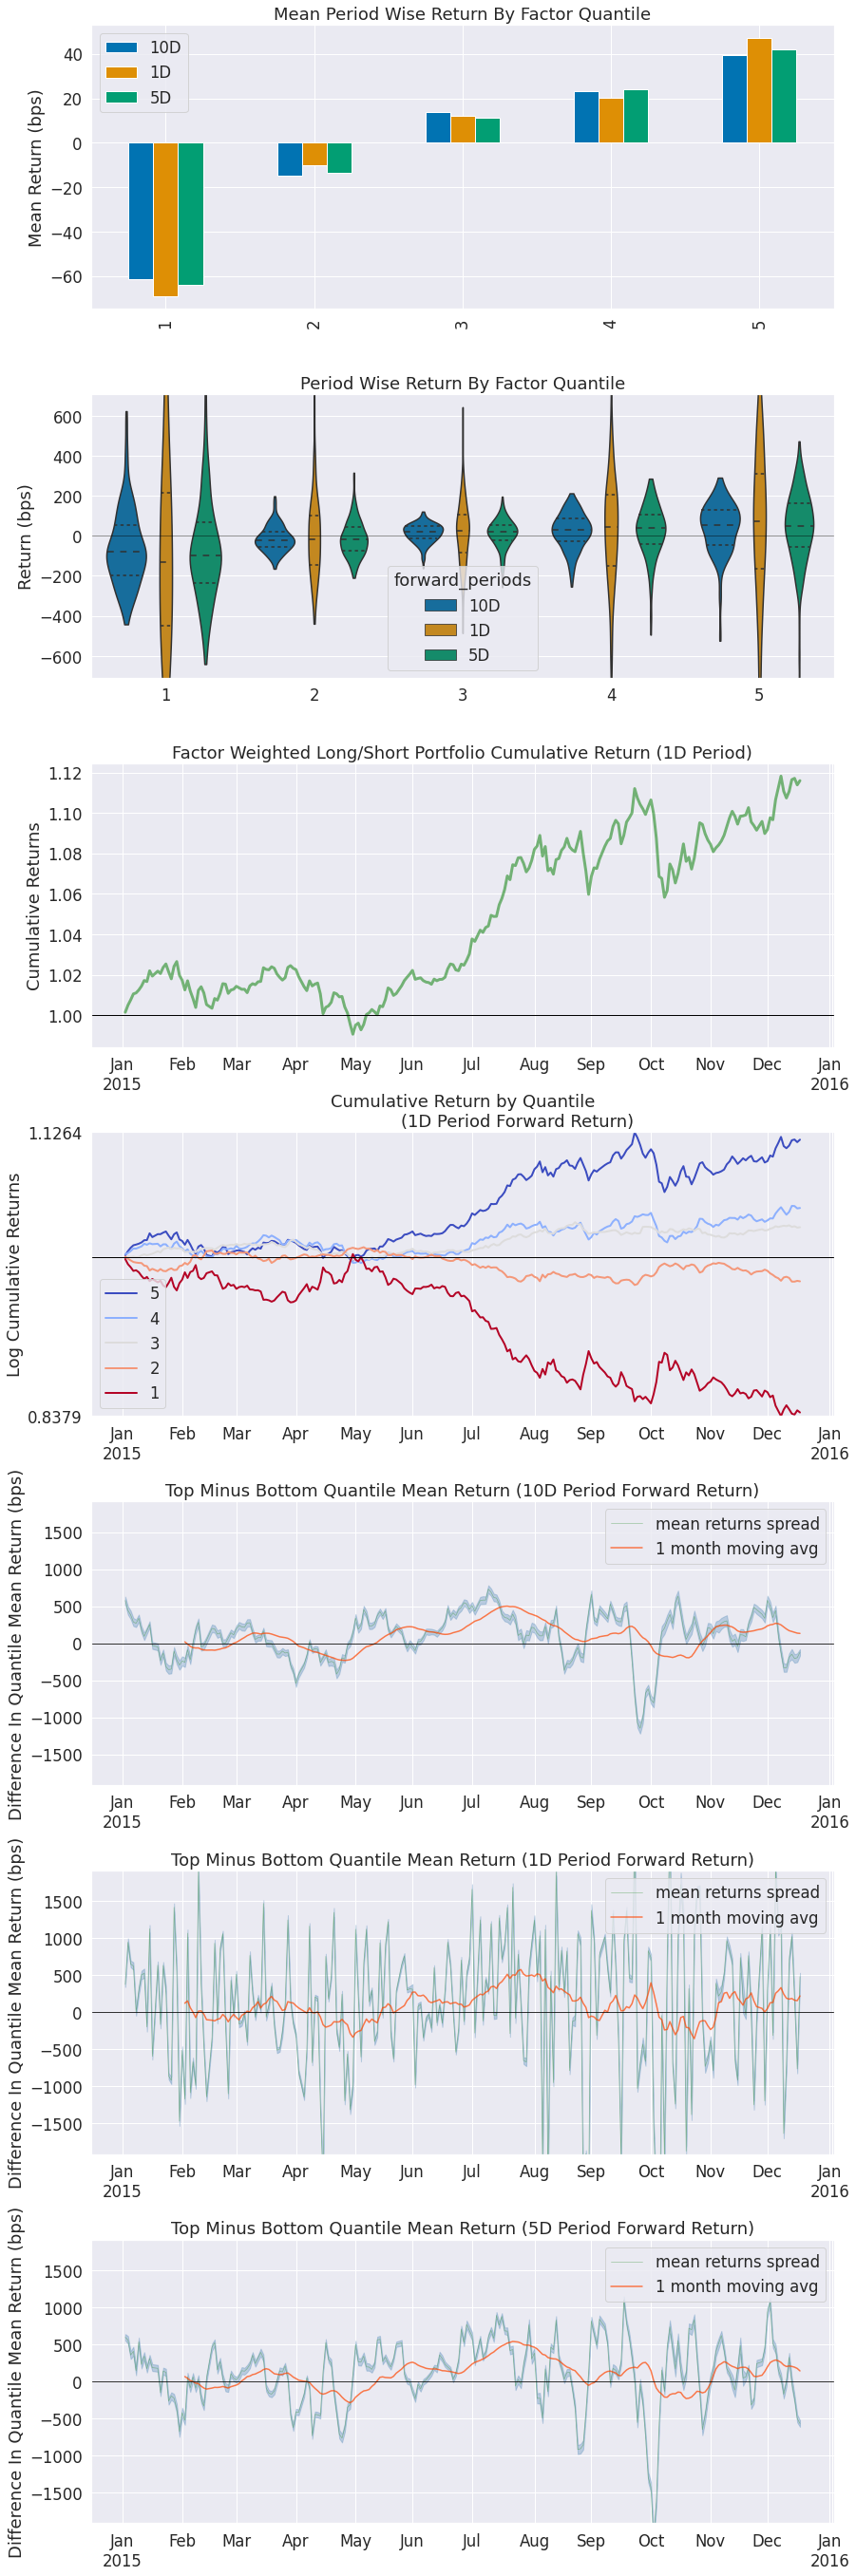

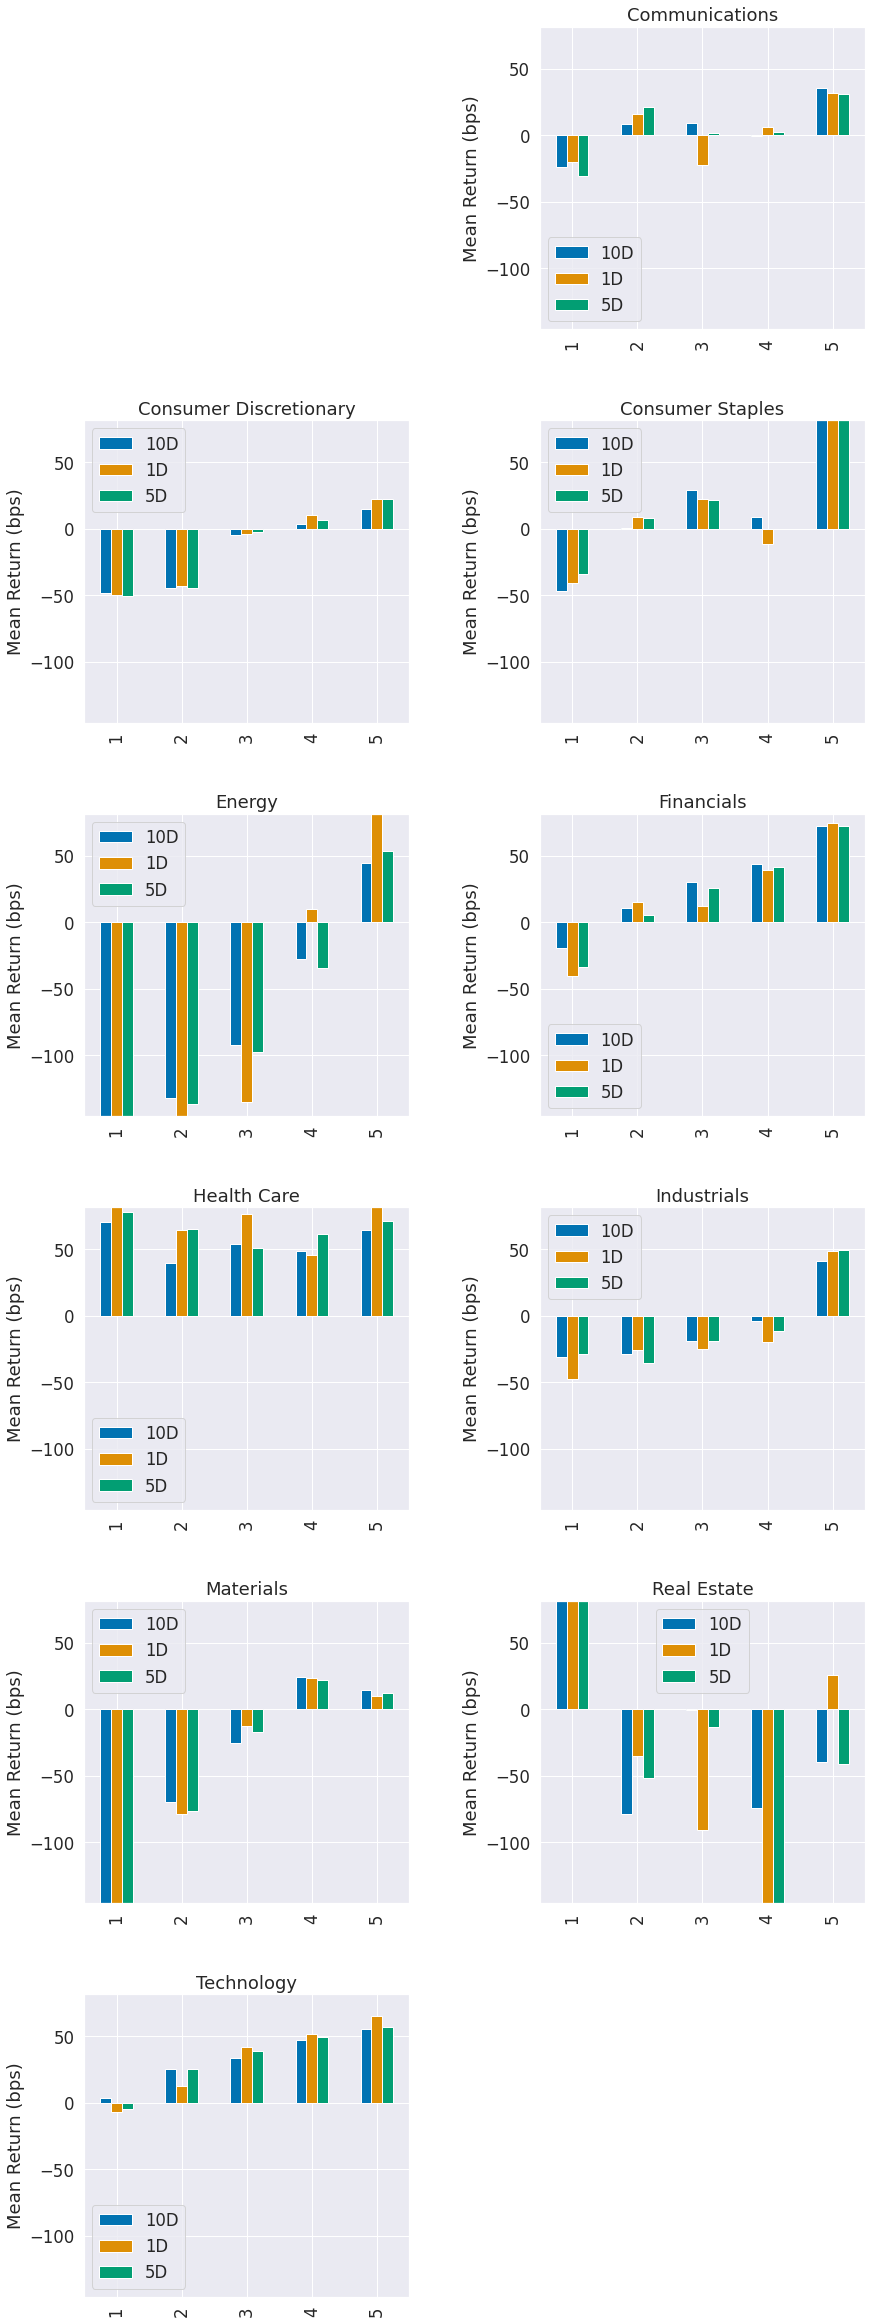

In [11]:
al.tears.create_returns_tear_sheet(factor_data, by_group=True);

### Returns Tear Sheet Breakdown

#### $\alpha$ and $\beta$ Point Estimates Table

The tear sheet calculates the $\alpha$ and $\beta$ of our factor with respect to the market. These are calculated by creating a regression of the market returns for each period against a long-short factor portfolio and extracting the parameters. These signify the excess return associated with our factor and the market beta, respectively.

#### Returns Point Estimates Table

These point estimates were also calculated agnostic of the sector groupings so they give us an overall view of what our spread would look like if we traded this factor with a long-short equity algorithm and didn't examine which sectors those returns were coming from.

#### Mean Period-Wise Return by Quantile

The quantized factor is used to create separate baskets, with returns for each basket calculated over each given day period. We get this information both as bar charts and as violin plots.

The bar charts provide us the mean return for each factor quantile, for each time horizon. This gives us a set of point estimates to get a preliminary understanding of how the factor value tracks with returns.

The primary difference between a bar chart and a violin plot is that a violin plot shows the density of our data. The fatter the violin, the higher the density of returns in that region. Here we plot the violins for the $1$, $5$, and $10$ day forward returns for each quantile.

#### Factor-Weighted Long/Short Portfolio Cumulative Return

These plots show the cumulative returns of a factor-weighted cross-sectional equity strategy based on the input factor. This holds the top quantile long and the bottom quantile short and simulates how that portfolio would perform without slippage or commissions. This shows the performance of the factor as a whole, which is always important to consider.

#### Cumulative Return by Quantile

This next plot aggregates the returns of each individual quantile into a plot of cumulative returns separated by basket for the 1-period forward returns. What we want here is to see five discrete "fingers" with few to no crossovers. This will give us an idea of which quantiles tend to drive the returns (ideally the first and fifth).

#### Quantile Mean Return in BPS

Next we calculate the basis points of the spread, based on subtracting the mean return of the lowest quantile from the mean return of the highest quantile (simulating going short on the lowest and long on the highest). We also get the error and plot it all together, giving us a time series of the basis points with confidence intervals for each time period.

#### Sector Breakdown of Returns

`Alphalens` provides a breakdown of returns by group, provided that you feed it a set of categorical values (such as industry labels), using the `by_group` flag. While it is good to consider breakdowns by quantile, it is also important to see how your factor is exposed to the different facets of the market. This is a good way to assess if your factor is behaving as it should in your universe. For example, if you intend your universe to only touch a certain sector, it is worthwhile to confirm that your factor and universe indeed only touch that sector.

## Information Coefficient

We use the information coefficient (IC) to assess the predictive power of a factor. The IC of a factor is its Spearman Rank Correlation. For more background on the mathematics associated with the IC, check out the Spearman Rank Correlation Lecture. To break it down, we calculate the IC between the factor values and the forward returns for each period. The IC assesses the monotonic relationship between factors and returns. What this means, intuitively, is that it provides a measure for whether higher factor values can be associated with higher returns.

A higher IC indicates that higher factor values are more closely associated with higher return values (and lower factor values with lower return values). A very negative IC indicates that higher factor values are closely associated with lower return values. An IC of $0$ indicates no relationship.

### Information Tear Sheet

Similarly to the returns tear sheet, we can also create a tear sheet that just gives us data on the information coefficient.

Information Analysis


,10D,1D,5D
IC Mean,0.063,0.032,0.056
IC Std.,0.166,0.165,0.161
Risk-Adjusted IC,0.383,0.196,0.347
t-stat(IC),5.965,3.050,5.412
p-value(IC),0.000,0.003,0.000
IC Skew,-0.414,-0.273,-0.391
IC Kurtosis,-0.204,-0.217,-0.034


/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<Figure size 1152x432 with 0 Axes>

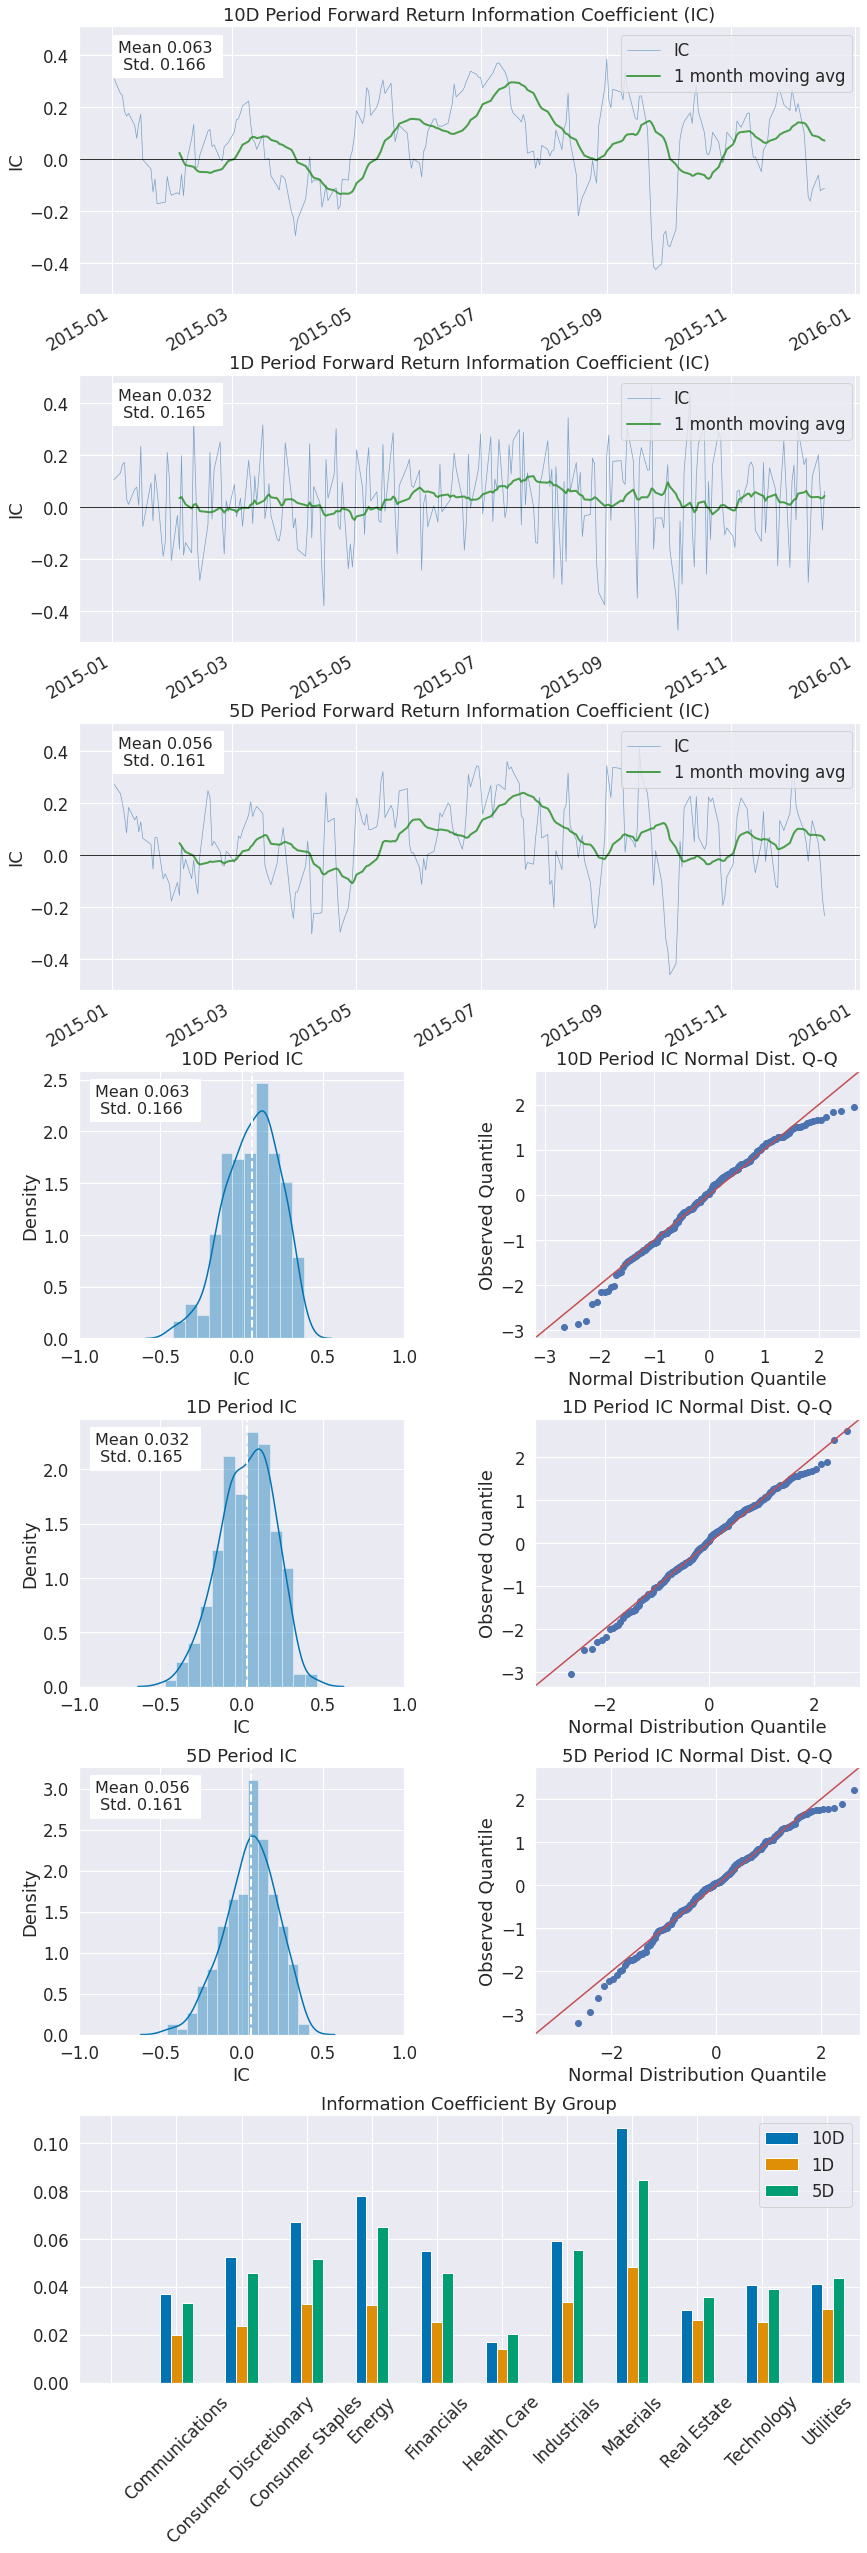

In [12]:
al.tears.create_information_tear_sheet(factor_data, by_group=True)

#### IC Point Estimates

This first table provides us with statistics around the distribution of the information coefficient for each time horizon. This includes mean, standard deviation, skewness, and kurtosis, to give us a clear view of how the distribution is shaped.

#### IC Time Series

Here we plot the IC as a time series for each period along with a 1-month moving average to smooth it out. What we want here is consistency over time and a consistently informative signal.

#### IC Histograms

Histograms are good to show us the distribution of the IC. These will clearly show any strange outliers and how they affect the overall curve.

#### IC QQ-Plots

A QQ-plot compares the distribution of the IC to the normal distribution. It plots the quantiles of one distribution against the quantiles of the other, typically with a reference line at $y = x$. If the points in the QQ-plot fall entirely along this line, this indicates that the two distributions are the same. In practice, a QQ-plot serves as a measure of similarity between distributions. Generally, what we want to see here is an S-shaped curve. This indicates that the tails of the IC distribution are fatter and contain more information.

#### IC by Group

Looking at the returns by quantile for each individual sector in the returns tear sheet helps to show which sectors are driving the bulk of our returns as well as whether quantiles in each sector are broken out how they should be (with the lowest quantiles giving the lowest returns up to the highest quantiles giving the highest returns). If an individual sector has little to no signal (IC), it makes sense for the quantile returns to be all over the place. Looking at IC by group helps to make sure that everything is behaving nicely.

## Turnover

When considering the impact of actually implementing a signal in a strategy, turnover is a critical thing to consider. This plot shows the turnover of the top and bottom quantiles of your factor, the baskets that you would actually be trading on with a long-short approach. Excessive turnover will eat away at the profits of your strategy through commission costs. Sometimes a signal just isn't good enough to fight against the tide on the scale that you have to deal with through your broker.

### Turnover Tear Sheet

We can examine two separate metrics of turnover using Alphalens, percent turnover and factor autocorrelation.

/tmp/alphalens/alphalens/utils.py:920: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.083,0.193,0.274
Quantile 2 Mean Turnover,0.181,0.386,0.499
Quantile 3 Mean Turnover,0.203,0.424,0.540
Quantile 4 Mean Turnover,0.180,0.385,0.504
Quantile 5 Mean Turnover,0.080,0.184,0.265


,10D,1D,5D
Mean Factor Rank Autocorrelation,0.869,0.985,0.931


<Figure size 1152x432 with 0 Axes>

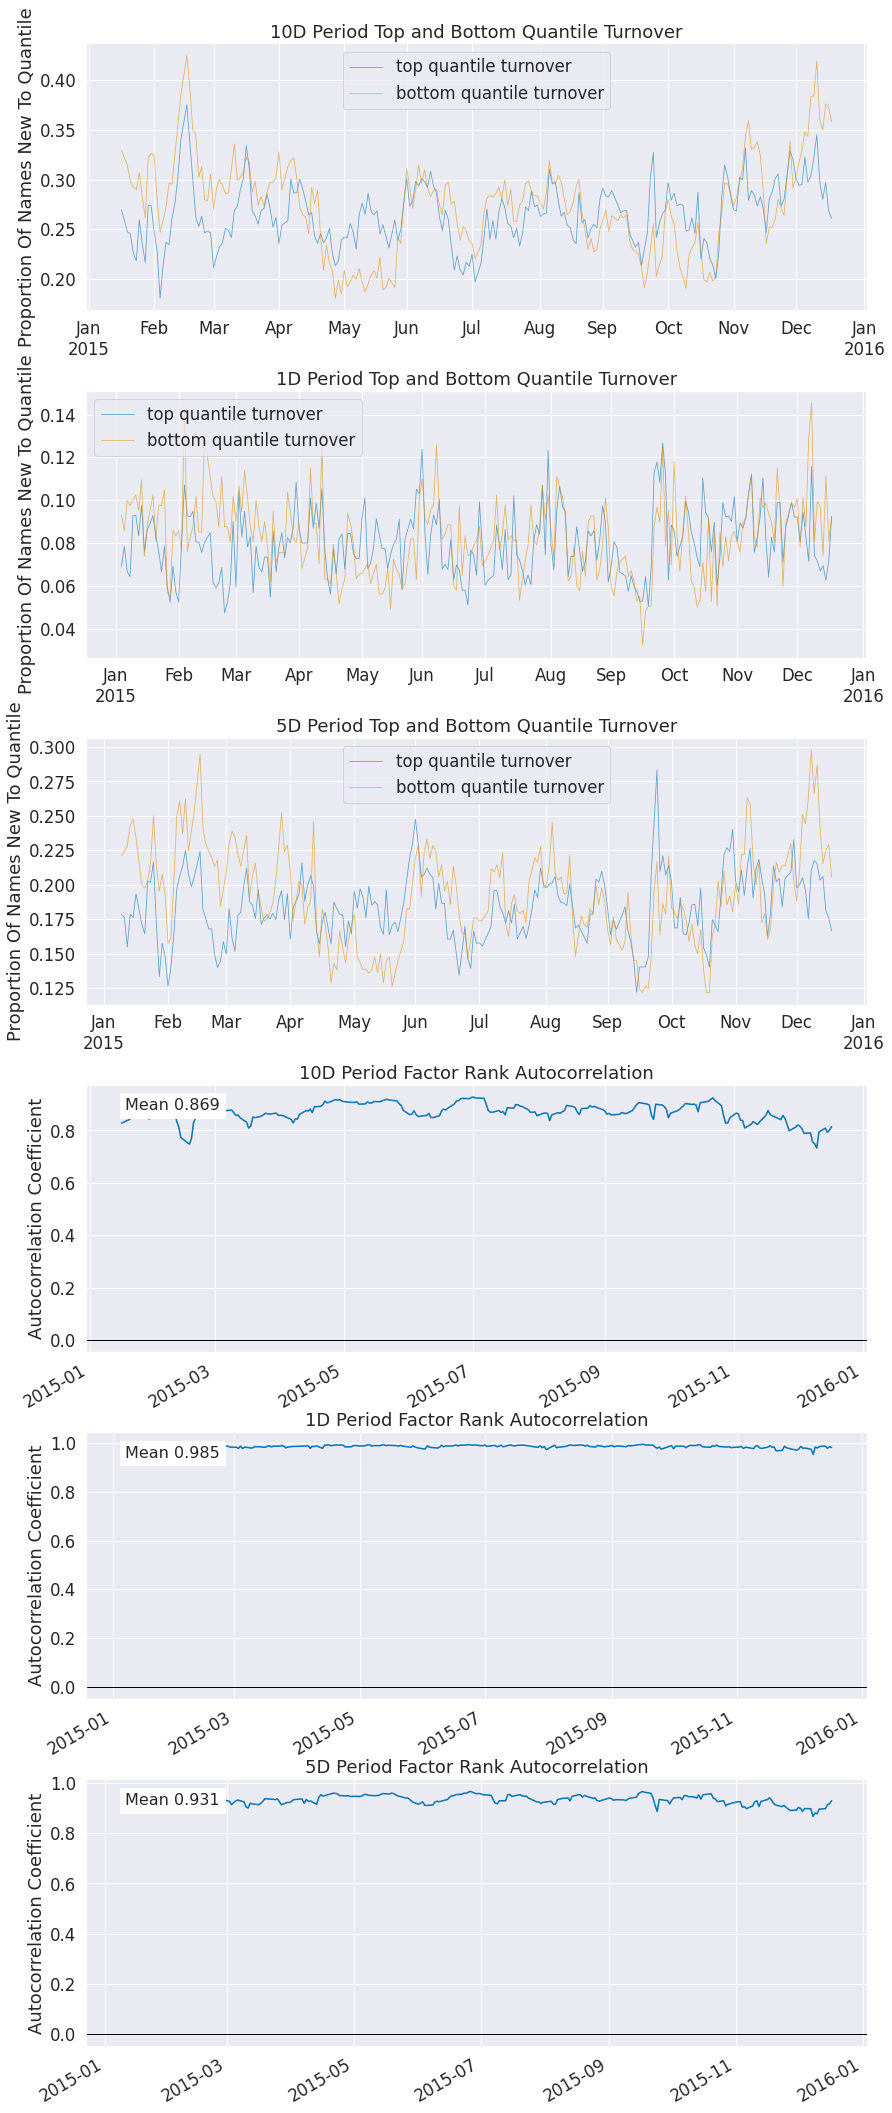

In [13]:
al.tears.create_turnover_tear_sheet(factor_data);

#### Quantile Turnover

The first table is a plot of turnover for each quantile by period. This indicates the percentage of names that move in and out of each basket.

#### Factor Autocorrelation

Factor autocorrelation is the measure of correlation between the current value of the factor and its previous value. The idea behind its calculation is to provide another measure of the turnover of the factor quantiles. If the autocorrelation is low, it implies that the current value of the factor has little to do with the previous value and that portfolio positions are changing frequently from time period to time period. If the next value of the factor is significantly influenced by its last value, this means that your ranking scheme is more consistent (though this has no influence on its ability to forecast relative price movements).

#### Top and Bottom Quantile Turnover
These plot shows a fairly ordinary turnover for the factor, implying that we will not be hit too hard by the constant changing of portfolio positions, though this varies from time period to time period. We cannot see the costs directly, however, because `Alphalens` does not model commission costs. It simply provides metrics that we can use to judge a factor by itself. To properly model undermining influences such as slippage and commissions you will need to implement a strategy that uses your factor in a backtest.


#### Autocorrelation

The second set of plots in the turnover tear sheet is the factor autocorrelation over time. In this case, we have fairly high autocorrelation, corroborating the turnover plots from above that suggest more consistent portfolio positions.

# Full Factor Tear Sheet

We can also generate all of the above plots and statistics in one complete tear sheet. The syntax for generating the full tear sheet all at once is as follows:

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-43.119655,-0.318163,-2.482942,1.403468,104237,20.017898
2,-2.633022,0.808088,-0.573863,0.559006,104102,19.991973
3,-1.285092,2.064035,0.543698,0.574289,104088,19.989284
4,-0.247498,3.562062,1.731096,0.645341,104102,19.991973
5,0.968624,14.811180,3.915375,1.517469,104190,20.008872


Returns Analysis


,10D,1D,5D
Ann. alpha,0.117,0.119,0.119
beta,-0.199,-0.072,-0.176
Mean Period Wise Return Top Quantile (bps),39.507,47.138,42.093
Mean Period Wise Return Bottom Quantile (bps),-61.353,-69.030,-63.805
Mean Period Wise Spread (bps),100.860,108.176,104.845


<Figure size 1152x432 with 0 Axes>

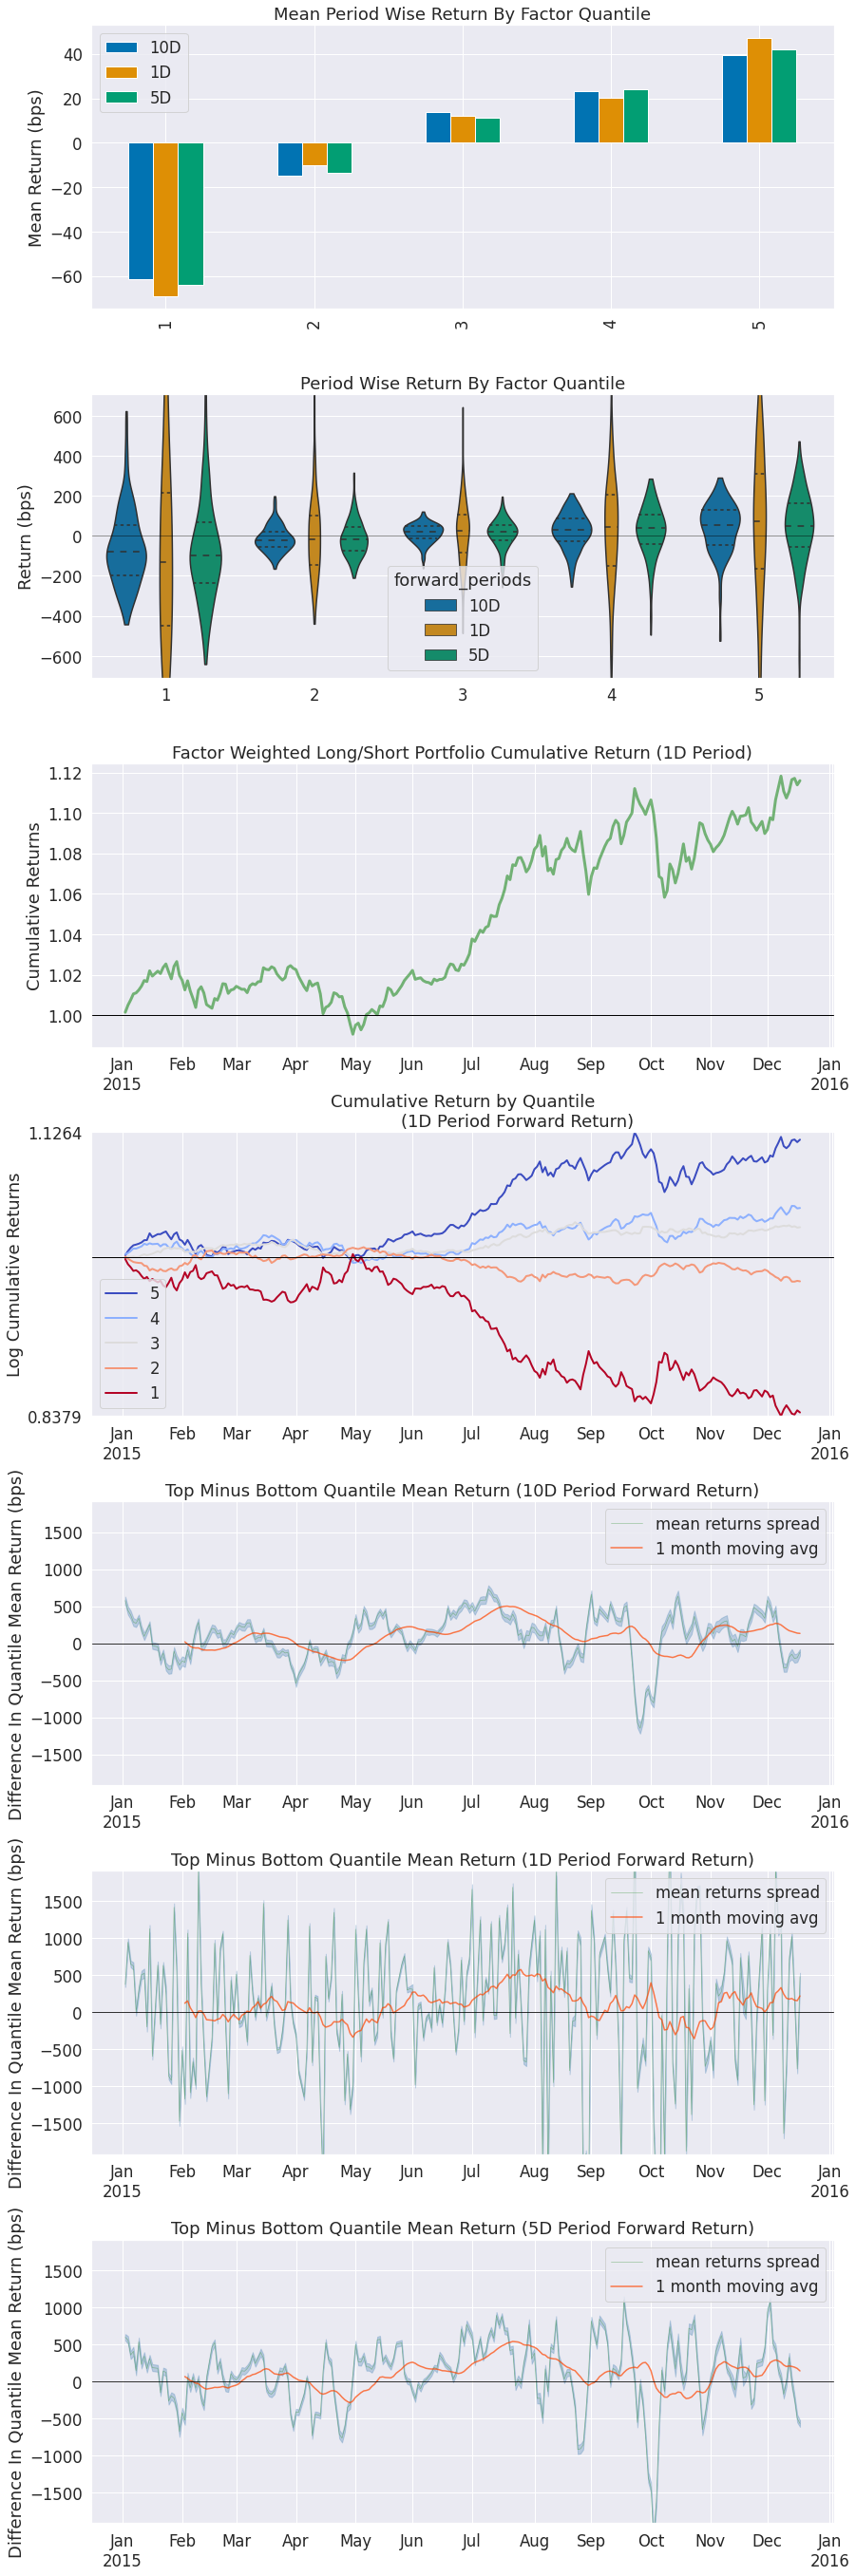

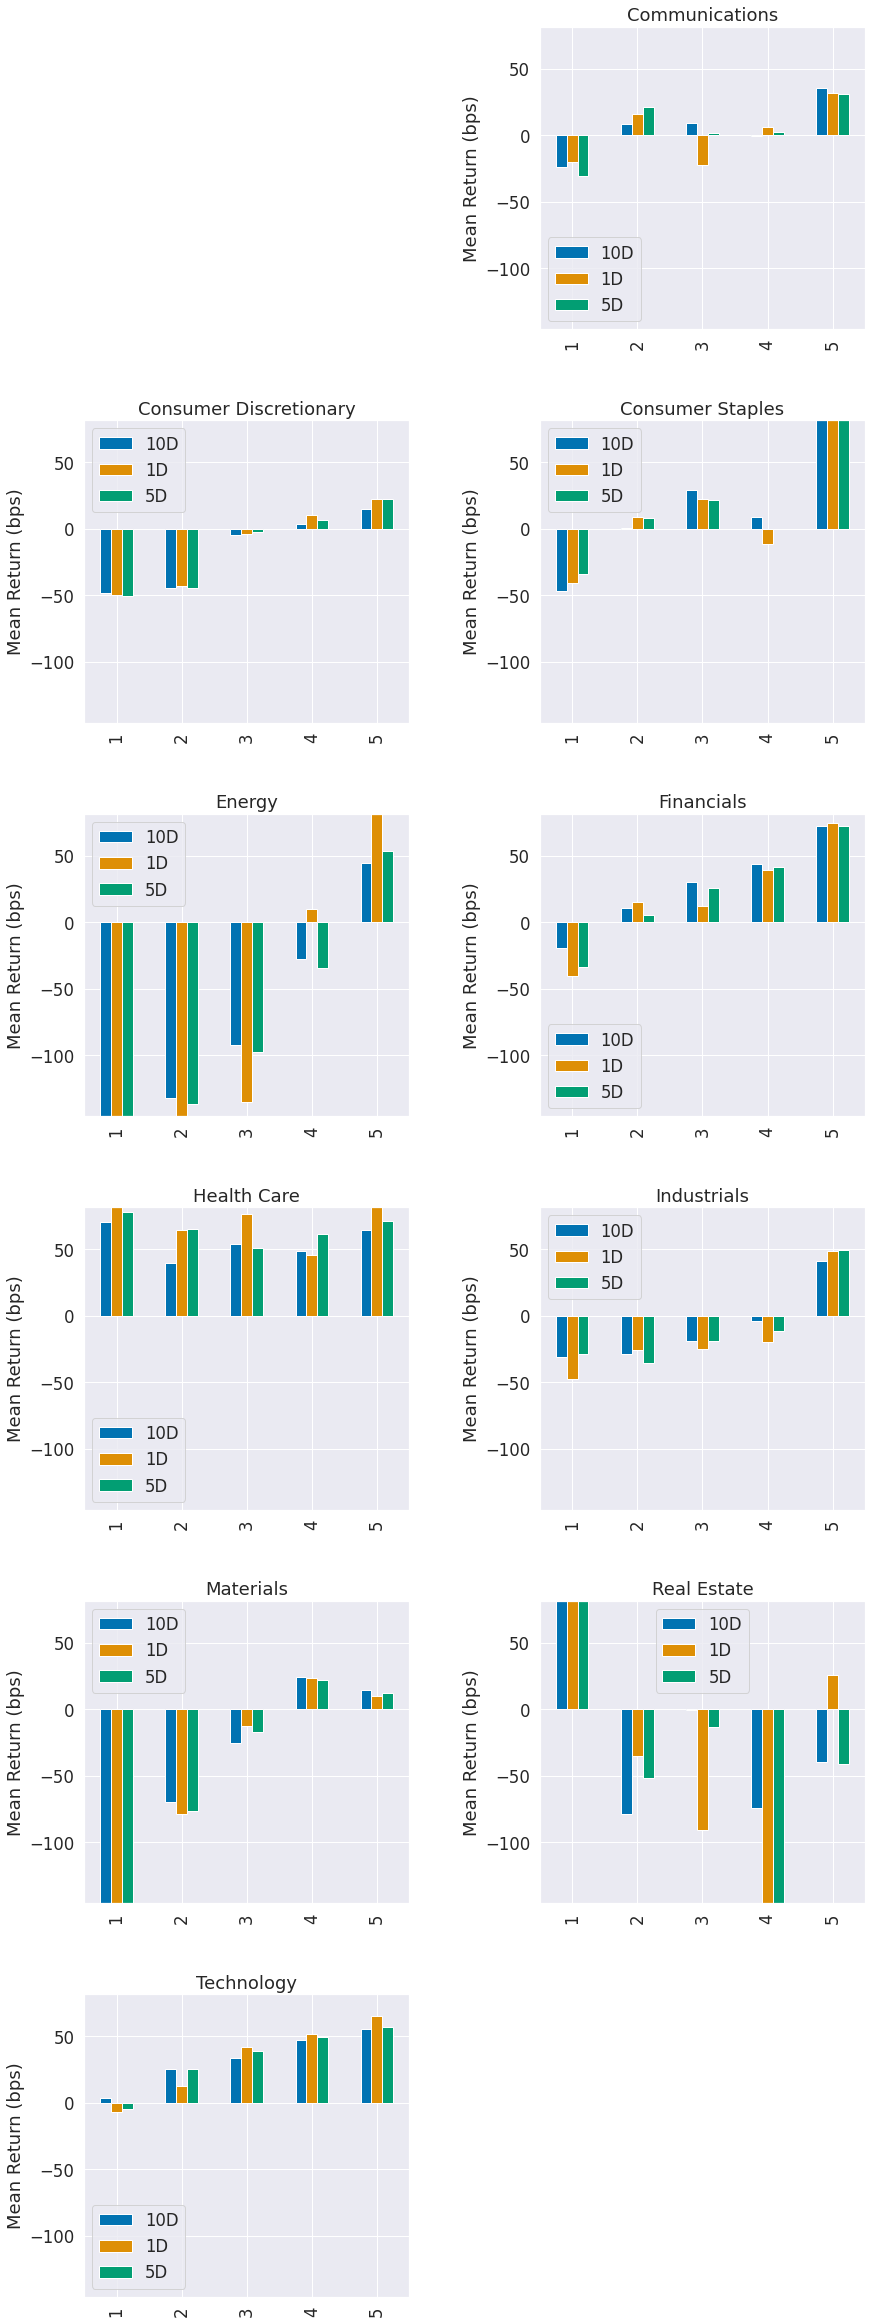

Information Analysis


,10D,1D,5D
IC Mean,0.063,0.032,0.056
IC Std.,0.166,0.165,0.161
Risk-Adjusted IC,0.383,0.196,0.347
t-stat(IC),5.965,3.050,5.412
p-value(IC),0.000,0.003,0.000
IC Skew,-0.414,-0.273,-0.391
IC Kurtosis,-0.204,-0.217,-0.034


/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/zipline/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

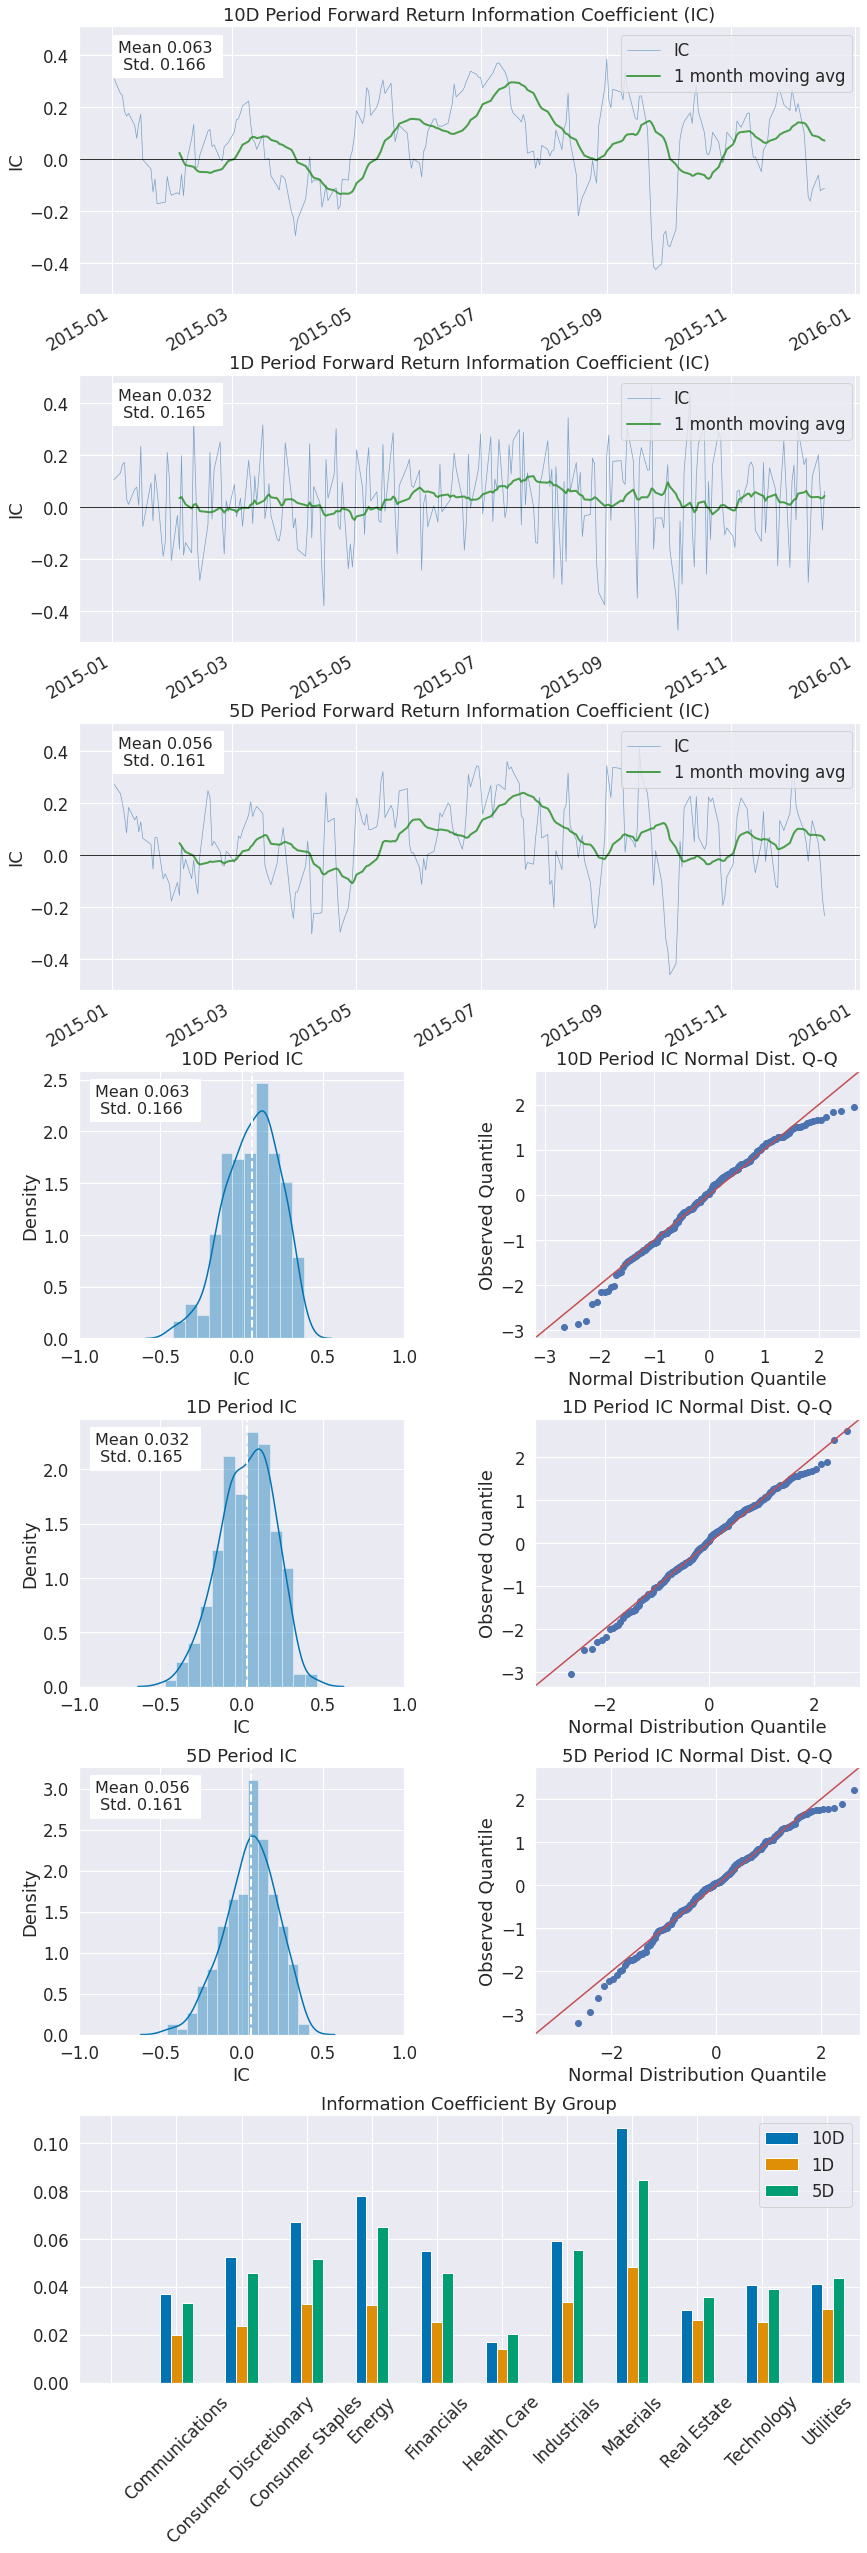

/tmp/alphalens/alphalens/utils.py:920: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.083,0.193,0.274
Quantile 2 Mean Turnover,0.181,0.386,0.499
Quantile 3 Mean Turnover,0.203,0.424,0.540
Quantile 4 Mean Turnover,0.180,0.385,0.504
Quantile 5 Mean Turnover,0.080,0.184,0.265


,10D,1D,5D
Mean Factor Rank Autocorrelation,0.869,0.985,0.931


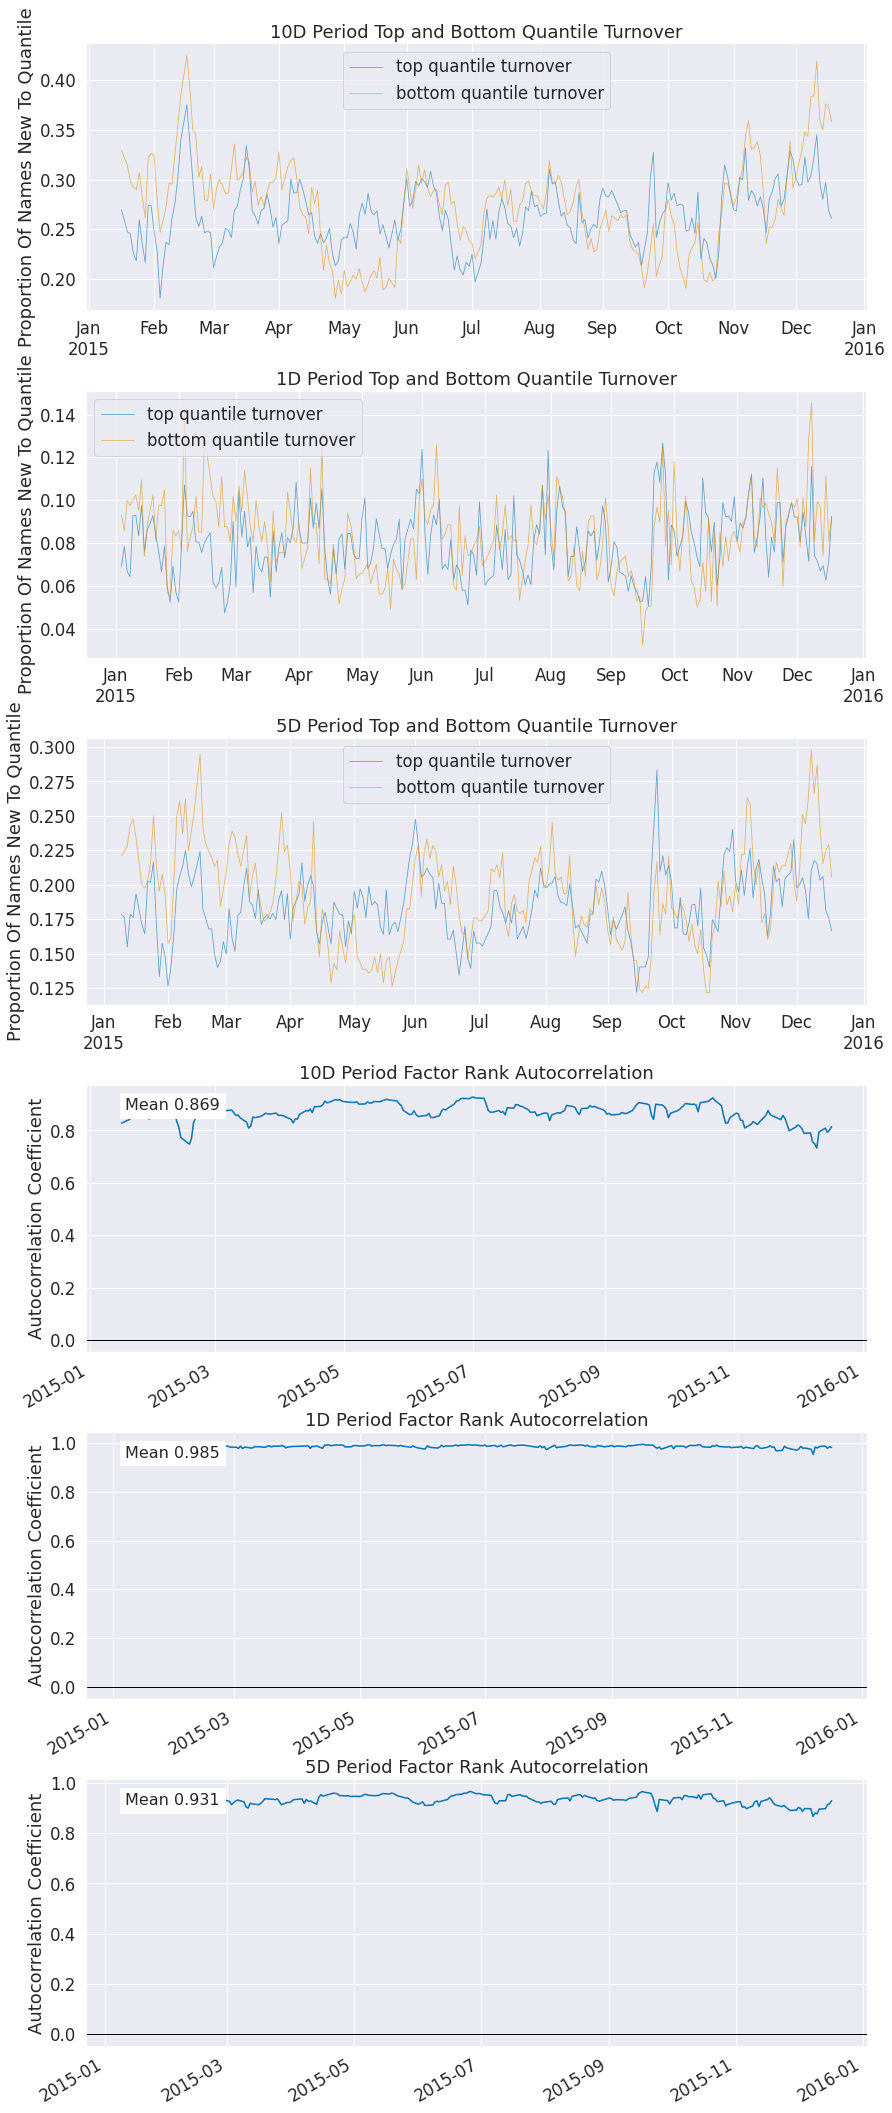

In [14]:
al.tears.create_full_tear_sheet(factor_data, by_group=True);

# More on Factors

Coming up with new factors is all well and good, but often you will need many independently predictive factors to produce a signal that is stable enough to trade. Methods of aggregating factors together will be discussed in future lectures, but the most simple initial approach would just be to normalize the values of each factor you would like to include in the aggregate, add the new normalized factor together, and rank by this new combined factor value.


# Next Steps

Once you have a factor that looks good, the next step is to implement it in an algorithm. Unfortunately, it isn't enough to simply have a good signal. Trading algorithms have to take into account many other considerations that are not included in `Alphalens`. We need to include how the market at large will react to the trades we're making (market impact/slippage) as well as the transaction costs associated with making those trades. These influences can erode our profits if we do not properly assess their impact through extensive testing.

To this end, we have full backtests using Zipline. It allows for slippage and transaction cost modeling and lets you set limitations for the amount of leverage (debt) that your algorithm can take on to make its trades. Learn more about leverage in the Leverage lecture.

---

**Next Lecture:** [Why You Should Hedge Beta and Sector Exposures](Lecture39-Why-Hedge.ipynb) 

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian") or QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, neither Quantopian nor QuantRocket has taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. Neither Quantopian nor QuantRocket makes any guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*